## makemore - MLP

### Implementing [Bengio, et al. 2003: A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

This implementation introduces:
- more sophisticated embeddings
- hyperparameters
- learning rate tuning
- train/test/dev set split
- under- and over-fitting

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

names = open('data/names.txt', 'r').read().splitlines()
print("Sample names: ", names[5:12])


# create char to index mapping for set (vocabulary) of chars in names
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print("Character mapping: ", itos)

Sample names:  ['charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily']
Character mapping:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Step by step exploration

In [27]:
# creating dataset: context and target pairs
# before, we used one-hot encoding; this will now be used for an embedding lookup table
# and eventually transform into modern vector embeddings 

context_length = 3 # how many chars to consider to predict the next char
X, Y = [], []
for name in names[8:13]:

    print("Name: ", name)
    context = [0] * context_length # initial context is all dots; this pads shorter words to match the context length
    for char in name + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # construct tokens 

X = torch.tensor(X)
Y = torch.tensor(Y)

print("X shape: ", X.shape, "   X.dtype: ", X.dtype) # X has shape (vocab_size, context_length)
print("Y shape: ", Y.shape, "      Y.dtype: ", Y.dtype)

Name:  harper
... -----> h
..h -----> a
.ha -----> r
har -----> p
arp -----> e
rpe -----> r
per -----> .
Name:  evelyn
... -----> e
..e -----> v
.ev -----> e
eve -----> l
vel -----> y
ely -----> n
lyn -----> .
Name:  abigail
... -----> a
..a -----> b
.ab -----> i
abi -----> g
big -----> a
iga -----> i
gai -----> l
ail -----> .
Name:  emily
... -----> e
..e -----> m
.em -----> i
emi -----> l
mil -----> y
ily -----> .
Name:  elizabeth
... -----> e
..e -----> l
.el -----> i
eli -----> z
liz -----> a
iza -----> b
zab -----> e
abe -----> t
bet -----> h
eth -----> .
X shape:  torch.Size([38, 3])    X.dtype:  torch.int64
Y shape:  torch.Size([38])       Y.dtype:  torch.int64


In [32]:
# creating embedding lookup table
C = torch.randn(27, 2) # embedding lookup table: 27 possible characters, each represented by a 2-dim vector

# C[X] "C at X" # (vocab_size, context_length) -> (vocab_size, context_length, embedding_dim)
emb = C[X] # embedding lookup: for every of the 38 tokens' 3 chars in X, we get a 2-dim vector from C
print(emb.shape)

emb[13,2] # for example, the embedding of the 3rd char in the 14th token in the dataset

torch.Size([38, 3, 2])


tensor([0.7360, 0.6085])

In [36]:
# constructing hidden layer 
# weights
W1 = torch.randn((6, 100)) # 6 (3 character embeddings*2 dimensions each), 100 neurons (variable we choose)
# biases
b1 = torch.randn(100) # 100 biases, one per neuron

In [41]:
# need 38 x 6 matrix to multiply with W1 - concatenate the 3 embeddings of 2 dimensions each
print(torch.cat([emb[:, 0, :] , emb[:, 1, :], emb[:, 2, :]], dim=1).shape) # each are (38, 2), treat as a sequence

# generalize the above concatenation for other context lengths with unbind
# however, cat is inefficient as it creates a new tensor in memory
print(torch.cat(torch.unbind(emb, 1), 1).shape) # unbind splits the tensor into a tuple of 3 tensors, each of shape (38, 2)

# to prevent any memory operation, optimize with view
emb.view(38,6)

# construct the hidden layer
# in the below, emb.shape[0] can be replaced with -1 to infer the size
# apply tanh to normalize
# note the addition: broadcasting adds b1 to each row of the matrix, as we want
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # (38, 6) @ (6, 100) -> (38, 100) + (100,) -> (38, 100)
h.shape

torch.Size([38, 6])
torch.Size([38, 6])


torch.Size([38, 100])

In [ ]:
# create output layer

# initializing weights and biases for output layer
W2 = torch.randn((100, 27)) # 100 neurons, 27 possible output chars
b2 = torch.randn(27) # 27 biases, one per output char

# outputs - logits
logits = h @ W2 + b2 # (38, 27)
logits.shape

torch.Size([38, 27])

In [ ]:
counts = logits.exp() # "fake counts"
prob = counts / counts.sum(1, keepdim=True) # normalize into probabilities
print(prob.shape)
prob[0].sum() # should be 1.0

torch.Size([38, 27])


tensor(1.0000)

In [51]:
print(prob[torch.arange(38), Y]) # probability of the correct next char for each of the 38 tokens
loss = -prob[torch.arange(38), Y].log().mean() # negative log likelihood loss
loss

tensor([4.4962e-11, 1.1478e-10, 7.1212e-08, 1.5932e-06, 7.3249e-07, 2.1359e-05,
        6.9399e-16, 7.5984e-01, 3.0265e-06, 4.4399e-02, 8.3797e-05, 3.1178e-05,
        1.0000e+00, 1.5385e-04, 1.7408e-09, 4.6086e-11, 4.7205e-11, 1.9919e-02,
        1.1926e-10, 1.7136e-11, 5.0008e-13, 1.1081e-08, 7.5984e-01, 5.8214e-04,
        7.5972e-16, 8.0738e-07, 4.3683e-08, 2.1018e-17, 7.5984e-01, 3.2249e-07,
        4.6499e-11, 3.0142e-09, 4.3560e-08, 2.8964e-06, 9.1366e-10, 1.2794e-06,
        6.0253e-13, 8.0574e-14])


tensor(16.8370)

### Training loop

In [ ]:
# creating dataset: context and target pairs

context_length = 3 # how many chars to consider to predict the next char
X, Y = [], []
for name in names:

    #print("Name: ", name)
    context = [0] * context_length # initial context is all dots; this pads shorter words to match the context length
    for char in name + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # construct tokens 

X = torch.tensor(X)
Y = torch.tensor(Y)

# dataset
print("X shape: ", X.shape, "   X.dtype: ", X.dtype) # X has shape (vocab_size, context_length)
print("Y shape: ", Y.shape, "      Y.dtype: ", Y.dtype)

X shape:  torch.Size([228148, 3])    X.dtype:  torch.int64
Y shape:  torch.Size([228148])       Y.dtype:  torch.int64


In [97]:
g = torch.Generator().manual_seed(978467474)
C = torch.randn(27, 2, generator=g) # embedding lookup table: 27 possible characters, each represented by a 2-dim vector
W1 = torch.randn((6, 100), generator=g) # 6 (3 character embeddings*2 dimensions each), 100 neurons (variable we choose)
b1 = torch.randn(100, generator=g) # 100 biases, one per neuron
W2 = torch.randn((100, 27), generator=g) # 100 neurons, 27 possible output chars
b2 = torch.randn(27, generator=g) # 27 biases, one per output char

parameters = [C, W1, b1, W2, b2] # all parameters of the model
print(sum(p.nelement() for p in parameters)) # number of parameters in the model
for p in parameters:
    p.requires_grad = True

3481


In [98]:
# learning rate search space
lre = torch.linspace(-3, 0, 1000) # log scale from 0.001 to 1.0
lrs = 10**lre

In [99]:
lri = []
lossi = []

def train(iterations, lr):
    for i in range(iterations): # training loop

        # batch
        ix = torch.randint(0, X.shape[0], (32,), generator=g) # random batch of 32 elements from the dataset

        # forward pass 
        emb = C[X[ix]] # embedding lookup: for every of the 38 tokens' 3 chars in X, we get a 2-dim vector from C
        h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # hidden layer
        logits = h @ W2 + b2 

        # same as the manual calculation from before, and more efficient (torch uses fused kernels, backward pass is simpler, well-behaved exp)
        loss = F.cross_entropy(logits, Y[ix])

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        #lr = lrs[i] # learning rate search
        for p in parameters:
            p.data += -lr * p.grad # gradient descent step

        # track learning rate search stats
        #lri.append(lre[i])
        #lossi.append(loss.item())

    # print(loss.item()) # loss per batch 

    emb = C[X] # embedding lookup: for every of the 38 tokens' 3 chars in X, we get a 2-dim vector from C
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1) # hidden layer
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y)
    print(loss.item()) # loss over entire training set 

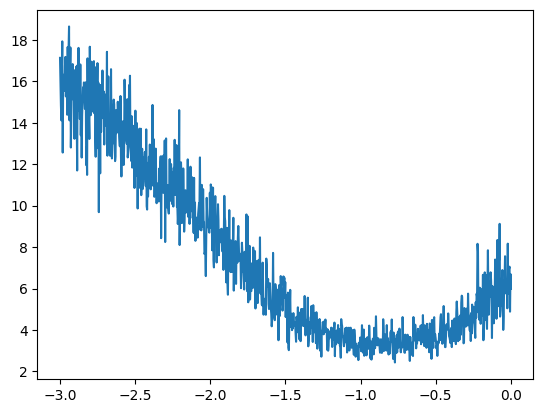

In [ ]:
plt.plot(lri, lossi)
# typical plot of learning rate vs loss; too high is unstable, too low is slow

In [ ]:
# from search chart, 10**-1 is a good learning rate
train(10000, 0.1)

2.4819912910461426


In [ ]:
# a few more
train(10000, 0.1)

2.376845121383667


In [104]:
# a learning rate decay once the above plateaus: crank up the iterations
train(100000, 0.01)

2.307384729385376


### Cleaned up

In [ ]:
# creating dataset: context and target pairs

context_length = 3 
X, Y = [], []
for name in names:

    context = [0] * context_length 
    for char in name + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

#### Exercises:
- [ ] E01: Tune the hyperparameters of the training to beat a validation loss of 2.2
- [ ] E02: (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- [ ] E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

### Exercise: 